In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


# What if AB Testing is like Science (and most results are false)? 

In [Why Most Published Research Findings Are False](http://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0020124) John Ioannidis argues that if most hypotheses we test are false, we end up with more false research findings than true findings, even if we do rigourous hypothesis testing.  The argument hinges on a vanilla application of Bayes' rule. Lets assume that science is "really hard" and that only 50 out of 1000 hypotheses we formulate are in fact true. Say we test our hypotheses at significance level alpha=0.05 and with power beta=0.80. Out of our 950 incorrect hypotheses, our hypothesis testing will lead to 950*0.05 = 47.5 false positives i.e. false research findings. Out of our 100 correct hypotheses, we will correctly identify 50*0.8 = 40 true research findings. To our horror, we find that most published findings are false!

Most applications of AB tesing involve running multiple repeated experiments in order to optmize a metric. At each iteration, we test a hypothesis: Does the new design perform better than the control? If so, we adopt the new design as our control and test the next idea. After many iterations, we expect to have a design that is better than when we started. But Ioannidis' argument about how most research findings could be false should make us wonder:

- Is it possible, that if the chances of generating a better new design are slim, that we  adopt bad designs more often than we adopt good designs? What effect does this have on our performance metric in the long run?
- How can we change our testing strategy in such a way that we still expect to increase performance over time? Conversely, how can we take advantage of a situation where the chances of generating a design that is better than the conrol is really high?


To investigate these questions, lets simulate the process of repeated AB testing for opimizing a click-through rate (CTR) under different scenarios for how hard our optimization problem is. I will model the difficulty of the problem using a distribution over the percent lift in (CTR) that a new idea has over the control. In practice we might expect the mean of this distribution to change with time.  As we work on a problem longer, the average idea probably gives a smaller performance increase. For our purposes, I will assume this distribution  (call it $I$) is fixed and normally distributed.

We start with a control banner with some fixed CTR. At each iteration, we test the control against a new banner whose percent lift in CTR over the control is drawn from $I$. If the new banner wins, it becomes the new control. We repeat this step several times to see what final CTR one sequence of tests leaves us with. I will refer to a single sequence of tests as a camapign. We can simulate several camapigns to characterize  the distribution of outcomes  we can expect at the end of a cmapaign.

## Code

For those who are interested, this section describes the simulation code. The `run_test` function, simulates running a single AB test. The paramters `mu` and `sigma` characterize $I$, the distribution over the percent gain in perfromance of a new design compared to the control. The parameters `alpha`, `beta` and `mde` correspond to the significance, power and minimum effect size of the hypothesis test used to determine if the new design beat the control. Finally `control_ctr` is the CTR of the control banner. This function simulates the creation of a new design, computing a sample size $n$ based on `control_ctr`, `alpha`, `beta` and `mde`, runnning the control and new design for $n$ iterations, and choosing the winning design.

In [61]:
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.power import tt_ind_solve_power


def sample_size_calculator(u_hat, mde=0.05, alpha=0.05, power=0.95):
    var_hat = u_hat*(1-u_hat)
    standardized_effect_size =  (u_hat - (u_hat*(1+mde))) / np.sqrt(var_hat)
    sample_size = tt_ind_solve_power(effect_size=standardized_effect_size, alpha=alpha, power=power)
    return sample_size


def run_test(mu, sigma, alpha, beta, mde, control_ctr, ):
    # create treatment banner with a lift drawn from the lift distribution
    lift = np.random.normal(mu, sigma)
    treatment_ctr = min(0.9, control_ctr*(1.0+lift/100.0))

    # run null hypothesis test with a fixed sample size
    N = sample_size_calculator(control_ctr, mde=mde, alpha=alpha, power=beta)
    n_c = np.random.binomial(N, control_ctr);
    n_t = np.random.binomial(N, treatment_ctr);
    p = chi2_contingency(np.array([[N-n_c,n_c], [N-n_t, n_t]]))[1]

    # if p > alpha, stick with the control
    if p > alpha:
        #return  control_ctr 
        return treatment_ctr

    # other wise pick the winner
    else:
        if n_c > n_t:
            return control_ctr
        else:
            return treatment_ctr
    

The  `run_campaign` implements running a sequnce of `num_tests` AB tests starting with a `base_rate` CTR.

In [30]:
def run_campaign(mu, sigma, alpha, beta, mde, base_rate, num_tests):
    true_rates = [base_rate, ]
    
    for i in range(num_tests):
        
        #the control of the current test is the winner of the last test
        control_rate = true_rates[-1]

        true_rates.append (run_test(mu, sigma, alpha, beta, mde, control_rate))
       
    return true_rates
        

The `expected_campaign_results` function implements running many campaigns with the same starting conditions. It generates a plot depicting the expected CTR as a function of the number of sequential AB test.

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs):
    fig = plt.figure(figsize=(10, 6), dpi=80)
    
    d = pd.DataFrame()
    for i in range(sim_runs):
        d[i] = run_campaign(mu, sigma, alpha, beta, mde, base_rate, num_tests)
        
    d2 = pd.DataFrame()
    d2['mean'] = d.mean(axis=1)
    d2['lower'] = d2['mean'] + 2*d.std(axis=1)
    d2['upper'] = d2['mean'] - 2*d.std(axis=1)
    
    plt.plot(d2.index, d2['mean'], label= 'CTR')
    plt.fill_between(d2.index, d2['lower'], d2['upper'], alpha=0.31, edgecolor='#3F7F4C', facecolor='0.75',linewidth=0)
    
    plt.xlabel('num tests')
    plt.ylabel('CTR')
    
    plt.plot(d2.index, [base_rate]*(num_tests+1), label = 'Start CTR')
    plt.legend()   

## Simulations


I will start out with a moderately pessimisitic scenario and assume the average new design is 5% worse than the control and that standard deviation `sigma` is 3. The plot below shows the distribution over percent gains from new designs.

For the hypothesis tests lets start out some idustry standard vlaues of `alpha` = 0.05, `beta` = 0.8 and `mde` = 0.10. The plot below shows the expected CTR after a simulating a sequence of 30 AB tests 100 times.

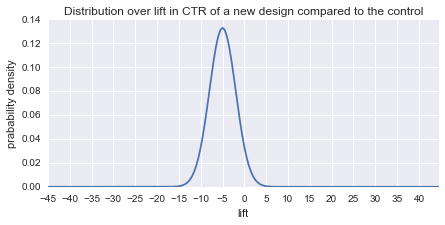

In [38]:
def plot_improvements(mu, sigma):
    plt.figure(figsize = (7, 3))
    x = np.arange(-45.0, 45.0, 0.5)
    plt.xticks(np.arange(-45.0, 45.0, 5))
    plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma**2) ))
    plt.xlabel('lift')
    plt.ylabel('prabability density')
    plt.title('Distribution over lift in CTR of a new design compared to the control')

#Distribution over % Improvements
mu = -5.0
sigma = 3

plot_improvements(mu, sigma)

In [33]:

# hypothesis test params
alpha = 0.05
beta = 0.8
mde = 0.10

#camapign params
num_tests = 30
base_rate = 0.2

#number of trials
sim_runs = 100

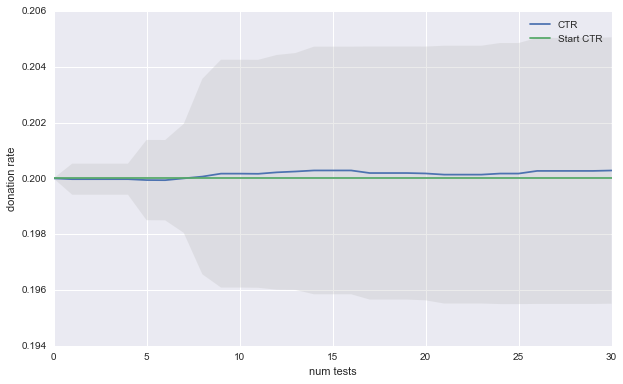

In [34]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

Even though we went through all work of runngin 100 AB test, we cannot expect to improve our CTR. The good news is that although most of our ideas were bad, doing the AB testing prevented us from loosing performance. The plot below shows what would happen if we had an undisciplined desinger who decided to use their new idea as the control when the hypothesis test could not discern a significant difference.

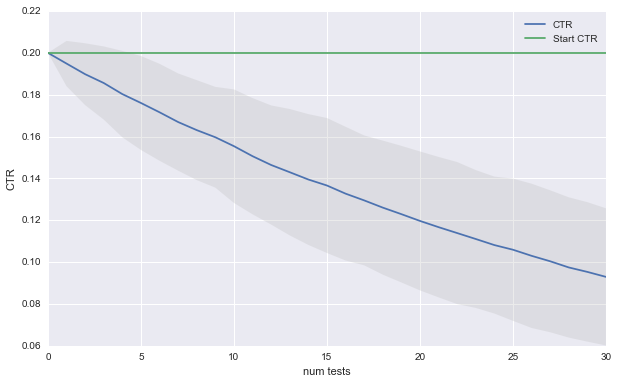

In [40]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

Impressive. The CTR starts tanking at a rapid pace. This is an extreme example but it spells out a clear warning: if your optimzation problem is hard, stick to your control.

Now lets imagine a world in which most ideas are neutral but there is still the potential for big wins and big losses. The plot below shows our new distribution over the quality of new iedeas.

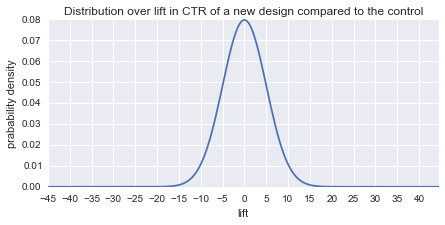

In [42]:
mu = 0.0
sigma = 5

plot_improvements(mu, sigma)

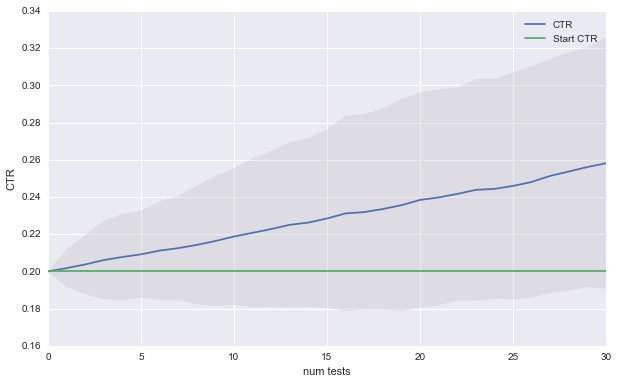

In [44]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

Now there is huge variance in how things could turn out. In expectation, we get a 2\% absolute gain every 10 tests. As you might have guessed, in this scenario it does not matter which banner you choose then the hypothsis test does not detect a significant difference. 

Lets see if we can reduce the variance in outcomes by decreasing the minimum detectable effect `mde` to 0.05. This will cost us in terms of runtime for each test, but it also should reduce the variance in the expected results.

In [48]:
mde = 0.05

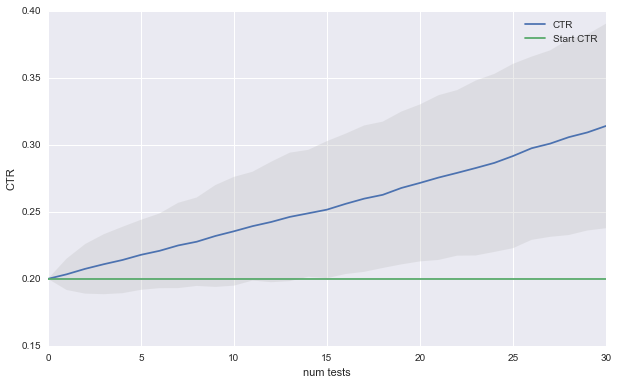

In [49]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

Now we can expect 5% absolute gain every 15 tests. It is very unlikey that we have not improved out CTR after 30 tests.

Finally, lets consider rosy scenario in which most new ideas are a winner. 

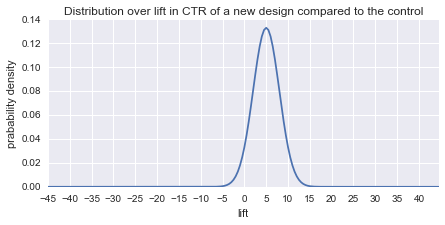

In [53]:
mu = 5
sigma = 3

plot_improvements(mu, sigma)

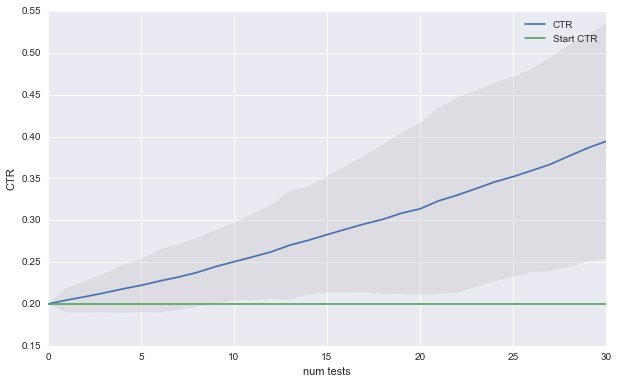

In [54]:
mde = 0.10
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

In [ ]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

Having good ideas is a recipe for runaway success. You might even decide that its foolish to choose the control banner when you don't have significance since chances are that your new idea is better, even if you could not detect it. The plot below shows that choosing the new idea over the control leads to even faster growth in performance.

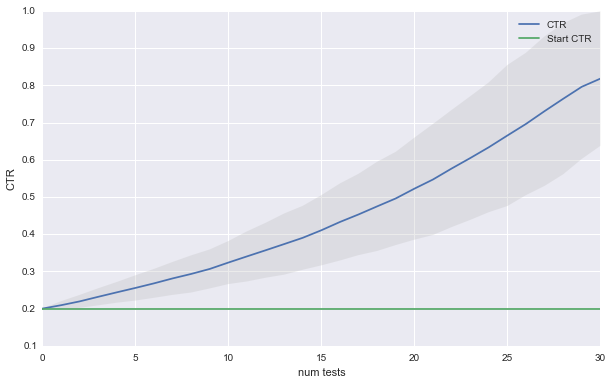

In [62]:
expected_campaign_results(mu, sigma, alpha, beta, mde, base_rate, num_tests, sim_runs)

I hope these simulations have given you some insight into the possible long term outcomes AB testing can achieve. Not surprisingly, whether you will be succesfull in increasing your performance metric has everything to do with the quality of your new designs. Even if your optmization problem is hard, however,  AB testing can give you ability to safely explore new ideas as long as you stick to your control in times of doubt. 

When most of your ideas have a neutral effect, AB testing helps you pick out the better ideas in expectation. As a result, performance does not simply oscillate around the starting point,  but steadily increases. 

If you are in the lucky position that your design team cannot miss, you are bound to succeed, whether you test or not. However, running AB tests will protect you from adopting a rare failed design. If you are in a hurry to boost your metric, you might consider going with new design when results are ambiguous. 

The results also suggest that it would be immensely useful to know which of these 3 scenarious most closely resembles your own. If your optimzation problem is hard, you might decide that designing further iterations is not worth the effort. If there is the possibility of large gains and losses, you might decide to run your tests longer, to decrease the variance in possible future outcomes. 


If you have already run a series of tests, you could gauge where you stand by looking at the distribution over the empirical gains of your new designs. For example, in the first simulation, gains are normally distributed with mean -5 and standard error 3. Lets assume that the true distribution over gains is also normally distributed. You could use the observed empirical gains to estimate the mean and standard error of the true distribution. I currently don't have a way of quantifying the uncertainy in these estimates, but it seems like a fun problem to explore next!





